In [1]:
from random import random
from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd



In [2]:
df = pd.read_csv(r'C:\Users\Vic\Documents\Studia\SN\Program_mentorski\RF_shap\Employee.csv')
df.head()

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
0,Bachelors,2017,Bangalore,3,34,Male,No,0,0
1,Bachelors,2013,Pune,1,28,Female,No,3,1
2,Bachelors,2014,New Delhi,3,38,Female,No,2,0
3,Masters,2016,Bangalore,3,27,Male,No,5,1
4,Masters,2017,Pune,3,24,Male,Yes,2,1


In [3]:
#typy danych 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4653 entries, 0 to 4652
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Education                  4653 non-null   object
 1   JoiningYear                4653 non-null   int64 
 2   City                       4653 non-null   object
 3   PaymentTier                4653 non-null   int64 
 4   Age                        4653 non-null   int64 
 5   Gender                     4653 non-null   object
 6   EverBenched                4653 non-null   object
 7   ExperienceInCurrentDomain  4653 non-null   int64 
 8   LeaveOrNot                 4653 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 327.3+ KB


In [7]:
# Zamiana tekstów na liczby
df['Gender'] = pd.factorize(df['Gender'])[0]
df['Education'] = pd.factorize(df['Education'])[0]
df['City'] = pd.factorize(df['City'])[0]

In [9]:
df['EverBenched'] = pd.factorize(df['EverBenched'])[0]

In [11]:
'''df = df.drop(columns='Name')
df = df.drop(columns='PassengerId')
# Zamiana tekstów na liczby
df['Sex'] = pd.factorize(df['Sex'])[0]
df['Ticket'] = pd.factorize(df['Ticket'])[0]
df['Cabin'] = pd.factorize(df['Cabin'])[0]
df['Embarked'] = pd.factorize(df['Embarked'])[0]'''

"df = df.drop(columns='Name')\ndf = df.drop(columns='PassengerId')\n# Zamiana tekstów na liczby\ndf['Sex'] = pd.factorize(df['Sex'])[0]\ndf['Ticket'] = pd.factorize(df['Ticket'])[0]\ndf['Cabin'] = pd.factorize(df['Cabin'])[0]\ndf['Embarked'] = pd.factorize(df['Embarked'])[0]"

In [13]:
#Czy są NaN
print(df.isnull().sum())

Education                    0
JoiningYear                  0
City                         0
PaymentTier                  0
Age                          0
Gender                       0
EverBenched                  0
ExperienceInCurrentDomain    0
LeaveOrNot                   0
dtype: int64


In [15]:
y_name = "LeaveOrNot"
#Nazwy kolumn - do watosci shap
feature_names = df.drop(columns=[y_name]).columns
#Tworzenie zbioru treningowego i testowego
df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)

#Podział 80% - 20%
train_size = int(0.8 * len(df_shuffled))
df_train = df_shuffled.iloc[:train_size]
df_test = df_shuffled.iloc[train_size:]

# Podział na y i X (pozostałe) 
if y_name in df.columns:
    y_train = df_train[y_name].values
    X_shap_train = df_train.drop(columns=[y_name])
    X_train = X_shap_train.values

    y_test = df_test[y_name].values
    X_shap_test = df_test.drop(columns=[y_name])
    X_test = X_shap_test.values
#X_train = pd.DataFrame(X_train, columns=feature_names)
#X_test = pd.DataFrame(X_test, columns=feature_names)
    # Sprawdzenie
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
print(type(X_test)) 
print(type(y_train))  


X_train shape: (3722, 8), y_train shape: (3722,)
X_test shape: (931, 8), y_test shape: (931,)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [17]:
print(np.unique(y_train))  
print(np.unique(y_test))   

[0 1]
[0 1]


In [19]:
from random import random
from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np
from RandomForestShap import RandomForestShap
import shap

def accuracy(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    return accuracy


C:\Users\Vic\.conda\envs\tf_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
import time
import tracemalloc
from sklearn.metrics import accuracy_score

def measure_training_and_prediction(model, X_train, y_train, X_test, y_test, call_number=1):
    print(f"\n📦 Wywołanie nr {call_number}")

    # ⏱️ + 💾 Trening
    tracemalloc.start()
    start_train = time.perf_counter()
    model.fit(X_train, y_train)
    end_train = time.perf_counter()
    current_train, peak_train = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    train_time = end_train - start_train
    train_mem = peak_train / (1024 * 1024)

    # ⏱️ + 💾 Predykcja
    tracemalloc.start()
    start_pred = time.perf_counter()
    predictions = model.predict(X_test)
    end_pred = time.perf_counter()
    current_pred, peak_pred = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    pred_time = end_pred - start_pred
    pred_mem = peak_pred / (1024 * 1024)

    # 🎯 Accuracy
    acc = accuracy_score(y_test, predictions)

    # 📤 Zwracamy metryki
    results = {
        "call_number": call_number,
        "train_time_s": round(train_time, 4),
        "train_memory_mb": round(train_mem, 4),
        "predict_time_s": round(pred_time, 4),
        "predict_memory_mb": round(pred_mem, 4),
        "accuracy": round(acc, 4)
    }

    # 🖨️ Wypisz wynik
    print(f"Train: {results['train_time_s']} s, {results['train_memory_mb']} MB | "
          f"Predict: {results['predict_time_s']} s, {results['predict_memory_mb']} MB | "
          f"Accuracy: {results['accuracy']}")

    return results


In [41]:
# Funkcja do mierzenia czasu trenowania
def check_prediction_time(X_test):
    start_time = time.time()
    predictions = clf_6.predict(X_test)
    return time.time() - start_time


In [43]:
import time
from sklearn.ensemble import RandomForestClassifier

# Funkcja do mierzenia czasu trenowania
def check_training_time(X_train, y_train):
    start_time = time.time()
    clf = RandomForestShap(n_trees=20)
    clf.fit(X_train, y_train)
    return time.time() - start_time

# Czas przed usunięciem kolumn
time_before = check_training_time(X_train, y_train)
print(f"Czas trenowania przed: {time_before:.2f} s")


Czas trenowania przed: 2.20 s


In [23]:
clf = RandomForestShap(n_trees=20)
results_all = []
i = 1
result = measure_training_and_prediction(clf, X_train, y_train, X_test, y_test, call_number=i)
results_all.append(result)


📦 Wywołanie nr 1
Train: 7.4897 s, 2.92 MB | Predict: 0.1011 s, 0.2896 MB | Accuracy: 0.841


In [45]:
clf = RandomForestShap(n_trees=20)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

acc =  accuracy(y_test, predictions)
print(acc)

0.849624060150376


In [47]:
import shap

# Używamy funkcji predict jako modelu
explainer = shap.Explainer(clf.predict, X_train, algorithm="permutation")

# Obliczamy wartości SHAP dla danych testowych
shap_values = explainer(X_test)


PermutationExplainer explainer: 932it [19:08,  1.24s/it]                         


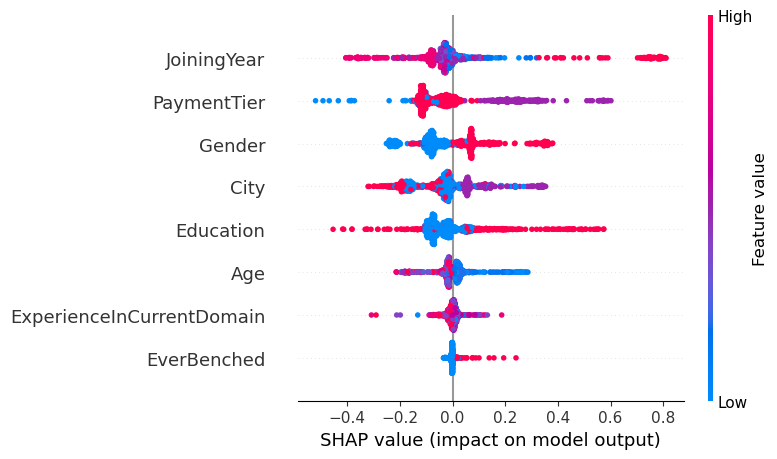

In [49]:
feature_names = X_shap_train.columns
shap.summary_plot(shap_values, X_test, feature_names=feature_names)


In [51]:
pd.set_option('display.max_rows', 1000)
#ranking cech - srednia wartosc SHAP
mean_abs = np.abs(shap_values.values).mean(axis=0)
feature_importance = pd.DataFrame({
    'Feature':[f"{i}" for i in (feature_names)], 'Mean SHAP value' : mean_abs})
feature_importance = feature_importance.sort_values('Mean SHAP value', ascending=False)

print(feature_importance)

                     Feature  Mean SHAP value
1                JoiningYear         0.116137
3                PaymentTier         0.113412
5                     Gender         0.105204
2                       City         0.090101
0                  Education         0.088546
4                        Age         0.039739
7  ExperienceInCurrentDomain         0.015156
6                EverBenched         0.005560


In [53]:
print(X_shap_test.columns)

Index(['Education', 'JoiningYear', 'City', 'PaymentTier', 'Age', 'Gender',
       'EverBenched', 'ExperienceInCurrentDomain'],
      dtype='object')


In [25]:
#Usuwanie kolumny Parch
X_shap_test = X_shap_test.drop(columns=['EverBenched'])
X_shap_train = X_shap_train.drop(columns=['EverBenched'])
X_train = X_shap_train.values
X_test = X_shap_test.values

In [27]:
i += 1
result = measure_training_and_prediction(clf, X_train, y_train, X_test, y_test, call_number=i)
results_all.append(result)


📦 Wywołanie nr 2
Train: 6.7802 s, 2.8812 MB | Predict: 0.0922 s, 0.2871 MB | Accuracy: 0.8485


In [57]:
# Czas po usunięciem kolumny 1
time_after1 = check_training_time(X_train, y_train)
print(f"Czas trenowania przed: {time_after1:.2f} s")

Czas trenowania przed: 2.13 s


In [59]:
#Kolejna predykcja
clf = RandomForestShap(n_trees=20)
clf.fit(X_train, y_train)
predictions_2 = clf.predict(X_test)

acc =  accuracy(y_test, predictions_2)
print(acc)

0.841031149301826


In [61]:
# Czas przed usunięciem kolumn
time_pred_before = check_prediction_time(X_test)
print(f"Czas predykcji po: {time_pred_before:.2f} s")


NameError: name 'clf_6' is not defined

In [65]:
# Używamy funkcji predict jako modelu
explainer = shap.Explainer(clf.predict, X_train, algorithm="permutation")

# Obliczamy wartości SHAP dla danych testowych
shap_values = explainer(X_test)


PermutationExplainer explainer: 932it [20:52,  1.36s/it]                         


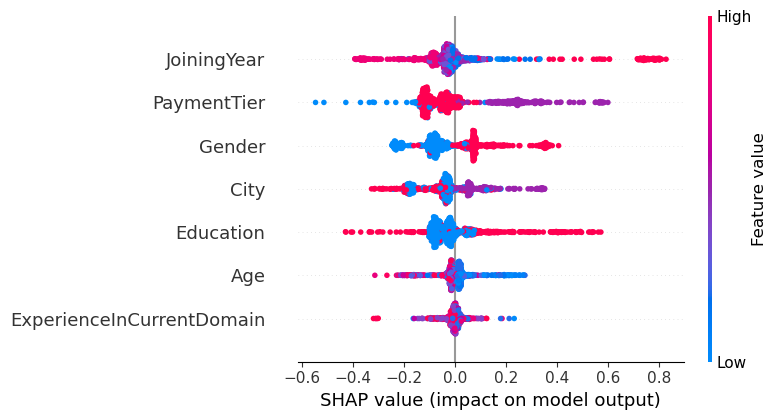

In [67]:
feature_names = X_shap_train.columns
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

In [69]:
#ranking cech - srednia wartosc SHAP
mean_abs = np.abs(shap_values.values).mean(axis=0)
feature_importance = pd.DataFrame({
    'Feature':[f"{i}" for i in (feature_names)], 'Mean SHAP value' : mean_abs})
feature_importance = feature_importance.sort_values('Mean SHAP value', ascending=False)

print(feature_importance)

                     Feature  Mean SHAP value
1                JoiningYear         0.117928
3                PaymentTier         0.113657
5                     Gender         0.110059
2                       City         0.090672
0                  Education         0.084268
4                        Age         0.039853
6  ExperienceInCurrentDomain         0.020895


In [29]:
#Usuwanie kolumny Parch
X_shap_test = X_shap_test.drop(columns=['ExperienceInCurrentDomain'])
X_shap_train = X_shap_train.drop(columns=['ExperienceInCurrentDomain' ])
X_train = X_shap_train.values
X_test = X_shap_test.values


In [31]:
i += 1
result = measure_training_and_prediction(clf, X_train, y_train, X_test, y_test, call_number=i)
results_all.append(result)


📦 Wywołanie nr 3
Train: 5.4353 s, 2.7855 MB | Predict: 0.0954 s, 0.2871 MB | Accuracy: 0.8464


In [73]:
print(X_train.shape)  # Sprawdzamy rozmiar danych po usunięciu kolumn
print(X_test.shape)   # To samo dla danych testowych


(3722, 6)
(931, 6)


In [75]:
# Czas przed usunięciem kolumn
time_before = check_training_time(X_train, y_train)
print(f"Czas trenowania po: {time_before:.2f} s")

Czas trenowania po: 1.71 s


In [77]:
#Kolejna predykcja
clf_3 = RandomForestShap(n_trees=20)
clf_3.fit(X_train, y_train)
predictions_3 = clf_3.predict(X_test)

acc =  accuracy(y_test, predictions_3)
print(acc)

0.841031149301826


In [75]:
# Czas przed usunięciem kolumn
time_pred_before = check_prediction_time(X_test)
print(f"Czas predykcji po: {time_pred_before:.2f} s")


Czas predykcji po: 0.04 s


In [79]:
# Używamy funkcji predict jako modelu
explainer = shap.Explainer(clf_3.predict, X_train, algorithm="permutation")

# Obliczamy wartości SHAP dla danych testowych
shap_values = explainer(X_test)


PermutationExplainer explainer: 932it [20:18,  1.32s/it]                         


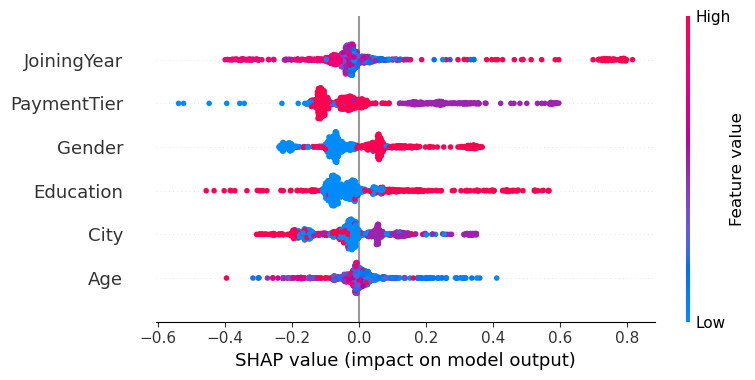

In [81]:
feature_names = X_shap_train.columns
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

In [83]:
pd.set_option('display.max_rows', 1000)
#ranking cech - srednia wartosc SHAP
mean_abs = np.abs(shap_values.values).mean(axis=0)
feature_importance = pd.DataFrame({
    'Feature':[f"{i}" for i in (feature_names)], 'Mean SHAP value' : mean_abs})
feature_importance = feature_importance.sort_values('Mean SHAP value', ascending=False)

print(feature_importance)

       Feature  Mean SHAP value
1  JoiningYear         0.115707
3  PaymentTier         0.113968
5       Gender         0.100161
0    Education         0.091922
2         City         0.087021
4          Age         0.045705


In [33]:
#Usuwanie kolumny Parch
X_shap_test = X_shap_test.drop(columns=['Age'])
X_shap_train = X_shap_train.drop(columns=['Age'])
X_train = X_shap_train.values
X_test = X_shap_test.values


In [35]:
i += 1
result = measure_training_and_prediction(clf, X_train, y_train, X_test, y_test, call_number=i)
results_all.append(result)


📦 Wywołanie nr 4
Train: 2.4501 s, 2.7868 MB | Predict: 0.0943 s, 0.2871 MB | Accuracy: 0.8443


In [87]:
# Czas przed usunięciem kolumn
time_before = check_training_time(X_train, y_train)
print(f"Czas trenowania przed: {time_before:.2f} s")

Czas trenowania przed: 0.81 s


In [89]:
#Kolejna predykcja
clf_4 = RandomForestShap(n_trees=20)
clf_4.fit(X_train, y_train)
predictions_4 = clf_4.predict(X_test)

acc =  accuracy(y_test, predictions_4)
print(acc)

0.8378088077336198


In [95]:
# Czas przed usunięciem kolumn
time_pred_before = check_prediction_time(X_test)
print(f"Czas predykcji po: {time_pred_before:.2f} s")


Czas predykcji po: 0.04 s


In [91]:
# Używamy funkcji predict jako modelu
explainer = shap.Explainer(clf_4.predict, X_train, algorithm="permutation")

# Obliczamy wartości SHAP dla danych testowych
shap_values = explainer(X_test)


PermutationExplainer explainer: 932it [19:10,  1.25s/it]                         


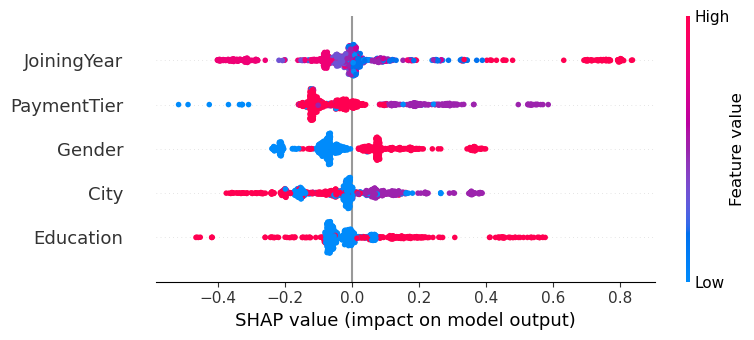

In [93]:
feature_names = X_shap_train.columns
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

In [95]:
#ranking cech - srednia wartosc SHAP
mean_abs = np.abs(shap_values.values).mean(axis=0)
feature_importance = pd.DataFrame({
    'Feature':[f"{i}" for i in (feature_names)], 'Mean SHAP value' : mean_abs})
feature_importance = feature_importance.sort_values('Mean SHAP value', ascending=False)

print(feature_importance)

       Feature  Mean SHAP value
1  JoiningYear         0.128079
3  PaymentTier         0.112463
4       Gender         0.106546
2         City         0.097515
0    Education         0.083359


In [37]:
#Usuwanie kolumny Parch
X_shap_test = X_shap_test.drop(columns=['Education'])
X_shap_train = X_shap_train.drop(columns=['Education'])
X_train = X_shap_train.values
X_test = X_shap_test.values


In [39]:
i += 1
result = measure_training_and_prediction(clf, X_train, y_train, X_test, y_test, call_number=i)
results_all.append(result)


📦 Wywołanie nr 5
Train: 1.8452 s, 2.3176 MB | Predict: 0.1047 s, 0.2871 MB | Accuracy: 0.8217


In [99]:
# Czas przed usunięciem kolumn
time_before = check_training_time(X_train, y_train)
print(f"Czas trenowania przed: {time_before:.2f} s")

Czas trenowania przed: 0.60 s


In [101]:
#Kolejna predykcja
clf_5 = RandomForestShap(n_trees=20)
clf_5.fit(X_train, y_train)
predictions_5 = clf_5.predict(X_test)

acc =  accuracy(y_test, predictions_5)
print(acc)

0.8206229860365198


In [113]:
# Czas przed usunięciem kolumn
time_pred_before = check_prediction_time(X_test)
print(f"Czas predykcji po: {time_pred_before:.2f} s")


Czas predykcji po: 0.04 s


In [103]:
# Używamy funkcji predict jako modelu
explainer = shap.Explainer(clf_5.predict, X_train, algorithm="permutation")

# Obliczamy wartości SHAP dla danych testowych
shap_values = explainer(X_test)


PermutationExplainer explainer: 932it [21:41,  1.41s/it]                         


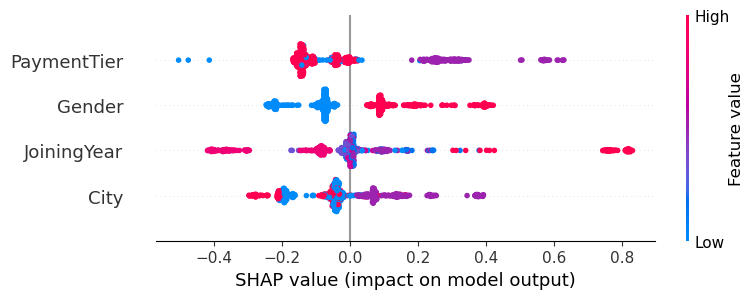

In [105]:
feature_names = X_shap_train.columns
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

In [107]:
#ranking cech - srednia wartosc SHAP
mean_abs = np.abs(shap_values.values).mean(axis=0)
feature_importance = pd.DataFrame({
    'Feature':[f"{i}" for i in (feature_names)], 'Mean SHAP value' : mean_abs})
feature_importance = feature_importance.sort_values('Mean SHAP value', ascending=False)

print(feature_importance)

       Feature  Mean SHAP value
2  PaymentTier         0.146968
3       Gender         0.127340
0  JoiningYear         0.124797
1         City         0.105459


In [41]:
#Usuwanie kolumny Parch
X_shap_test = X_shap_test.drop(columns=['City'])
X_shap_train = X_shap_train.drop(columns=['City'])
X_train = X_shap_train.values
X_test = X_shap_test.values


In [43]:
i += 1
result = measure_training_and_prediction(clf, X_train, y_train, X_test, y_test, call_number=i)
results_all.append(result)


📦 Wywołanie nr 6
Train: 0.9903 s, 1.6774 MB | Predict: 0.1021 s, 0.2871 MB | Accuracy: 0.8013


In [111]:
# Czas przed usunięciem kolumn
time_before = check_training_time(X_train, y_train)
print(f"Czas trenowania przed: {time_before:.2f} s")

Czas trenowania przed: 0.32 s


In [113]:
#Kolejna predykcja
clf_6 = RandomForestShap(n_trees=20)
clf_6.fit(X_train, y_train)
predictions_6 = clf_6.predict(X_test)

acc =  accuracy(y_test, predictions_6)
print(acc)

0.8012889366272825


In [129]:
# Czas przed usunięciem kolumn
time_pred_before = check_prediction_time(X_test)
print(f"Czas predykcji po: {time_pred_before:.2f} s")


Czas predykcji po: 0.04 s


In [115]:
# Używamy funkcji predict jako modelu
explainer = shap.Explainer(clf_6.predict, X_train, algorithm="permutation")

# Obliczamy wartości SHAP dla danych testowych
shap_values = explainer(X_test)


PermutationExplainer explainer: 932it [21:49,  1.42s/it]                         


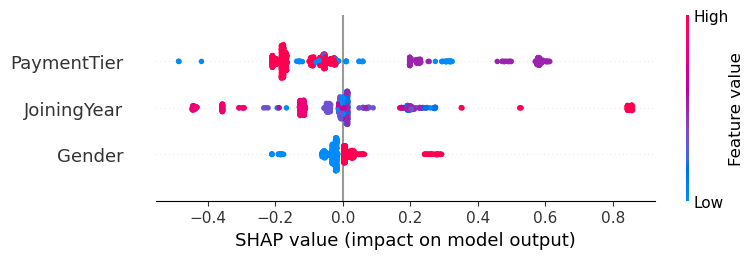

In [117]:
feature_names = X_shap_train.columns
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

In [119]:
#ranking cech - srednia wartosc SHAP
mean_abs = np.abs(shap_values.values).mean(axis=0)
feature_importance = pd.DataFrame({
    'Feature':[f"{i}" for i in (feature_names)], 'Mean SHAP value' : mean_abs})
feature_importance = feature_importance.sort_values('Mean SHAP value', ascending=False)

print(feature_importance)

       Feature  Mean SHAP value
1  PaymentTier         0.182816
0  JoiningYear         0.156665
2       Gender         0.032780


In [45]:
#Usuwanie kolumny Parch
X_shap_test = X_shap_test.drop(columns=['Gender'])
X_shap_train = X_shap_train.drop(columns=['Gender'])
X_train = X_shap_train.values
X_test = X_shap_test.values


In [47]:
i += 1
result = measure_training_and_prediction(clf, X_train, y_train, X_test, y_test, call_number=i)
results_all.append(result)


📦 Wywołanie nr 7
Train: 0.6025 s, 1.2781 MB | Predict: 0.101 s, 0.2871 MB | Accuracy: 0.8024


In [123]:
# Czas przed usunięciem kolumn
time_before = check_training_time(X_train, y_train)
print(f"Czas trenowania przed: {time_before:.2f} s")

Czas trenowania przed: 0.18 s


In [125]:
#Kolejna predykcja
clf_6 = RandomForestShap(n_trees=20)
clf_6.fit(X_train, y_train)
predictions_6 = clf_6.predict(X_test)

acc =  accuracy(y_test, predictions_6)
print(acc)

0.8023630504833512


In [127]:
# Używamy funkcji predict jako modelu
explainer = shap.Explainer(clf_6.predict, X_train, algorithm="permutation")

# Obliczamy wartości SHAP dla danych testowych
shap_values = explainer(X_test)


PermutationExplainer explainer: 932it [24:17,  1.58s/it]                         


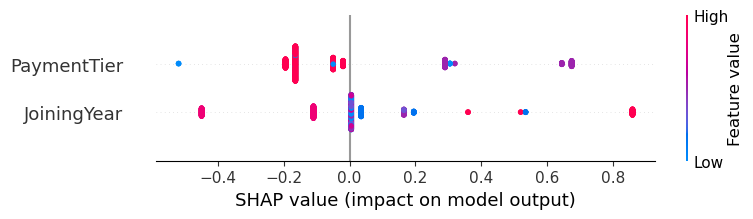

In [129]:
feature_names = X_shap_train.columns
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

In [131]:
#ranking cech - srednia wartosc SHAP
mean_abs = np.abs(shap_values.values).mean(axis=0)
feature_importance = pd.DataFrame({
    'Feature':[f"{i}" for i in (feature_names)], 'Mean SHAP value' : mean_abs})
feature_importance = feature_importance.sort_values('Mean SHAP value', ascending=False)

print(feature_importance)

       Feature  Mean SHAP value
1  PaymentTier         0.201369
0  JoiningYear         0.155999


In [225]:
#Usuwanie kolumny Parch
X_shap_test = X_shap_test.drop(columns=[' Degree of Financial Leverage (DFL)', ' Inventory/Working Capital', ' Net profit before tax/Paid-in capital',
' Operating profit per person', ' Cash Turnover Rate'])
X_shap_train = X_shap_train.drop(columns=[' Degree of Financial Leverage (DFL)', ' Inventory/Working Capital', ' Net profit before tax/Paid-in capital',
' Operating profit per person', ' Cash Turnover Rate'])
X_train = X_shap_train.values
X_test = X_shap_test.values


In [155]:
# Czas przed usunięciem kolumn
time_before = check_training_time(X_train, y_train)
print(f"Czas trenowania przed: {time_before:.2f} s")

Czas trenowania przed: 93.48 s


In [157]:
#Kolejna predykcja
clf_6 = RandomForestShap(n_trees=20)
clf_6.fit(X_train, y_train)
predictions_6 = clf_6.predict(X_test)

acc =  accuracy(y_test, predictions_6)
print(acc)

0.9699413489736071


In [159]:
# Używamy funkcji predict jako modelu
explainer = shap.Explainer(clf_6.predict, X_train, algorithm="permutation")

# Obliczamy wartości SHAP dla danych testowych
shap_values = explainer(X_test)


PermutationExplainer explainer: 1365it [25:19,  1.12s/it]                          


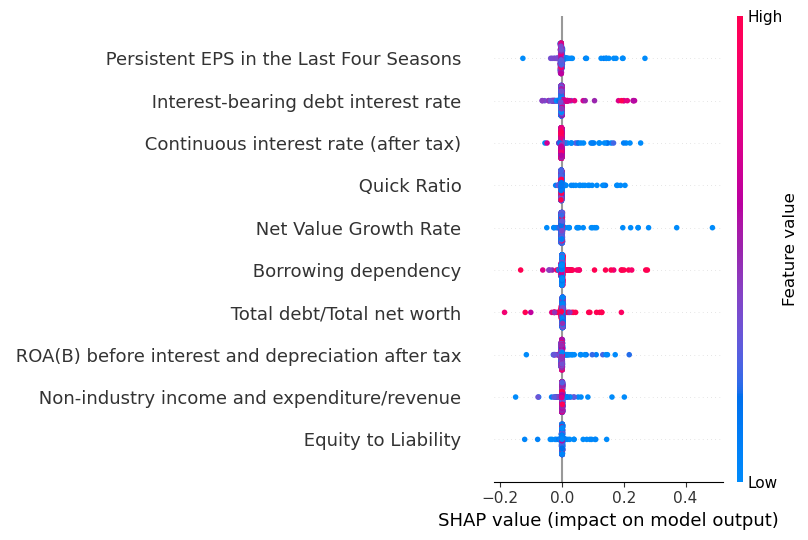

In [161]:
feature_names = X_shap_train.columns
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

In [163]:
#ranking cech - srednia wartosc SHAP
mean_abs = np.abs(shap_values.values).mean(axis=0)
feature_importance = pd.DataFrame({
    'Feature':[f"{i}" for i in (feature_names)], 'Mean SHAP value' : mean_abs})
feature_importance = feature_importance.sort_values('Mean SHAP value', ascending=False)

print(feature_importance)

                                             Feature  Mean SHAP value
4            Persistent EPS in the Last Four Seasons         0.004476
3                Interest-bearing debt interest rate         0.004343
2               Continuous interest rate (after tax)         0.004134
6                                        Quick Ratio         0.003694
5                              Net Value Growth Rate         0.003314
8                               Borrowing dependency         0.003281
7                         Total debt/Total net worth         0.002700
0   ROA(B) before interest and depreciation after...         0.002311
1        Non-industry income and expenditure/revenue         0.001402
9                                Equity to Liability         0.001333


In [227]:
#Usuwanie kolumny Parch
X_shap_test = X_shap_test.drop(columns=[' Total debt/Total net worth', ' ROA(B) before interest and depreciation after tax',
' Non-industry income and expenditure/revenue', ' Equity to Liability'])
X_shap_train = X_shap_train.drop(columns=[' Total debt/Total net worth', ' ROA(B) before interest and depreciation after tax',
' Non-industry income and expenditure/revenue', ' Equity to Liability'])
X_train = X_shap_train.values
X_test = X_shap_test.values

In [167]:
# Czas przed usunięciem kolumn
time_before = check_training_time(X_train, y_train)
print(f"Czas trenowania przed: {time_before:.2f} s")

Czas trenowania przed: 51.95 s


In [169]:
#Kolejna predykcja
clf_7 = RandomForestShap(n_trees=20)
clf_7.fit(X_train, y_train)
predictions_7 = clf_7.predict(X_test)

acc =  accuracy(y_test, predictions_7)
print(acc)

0.9706744868035191


In [171]:
# Używamy funkcji predict jako modelu
explainer = shap.Explainer(clf_7.predict, X_train, algorithm="permutation")

# Obliczamy wartości SHAP dla danych testowych
shap_values = explainer(X_test)


PermutationExplainer explainer: 1365it [25:52,  1.14s/it]                          


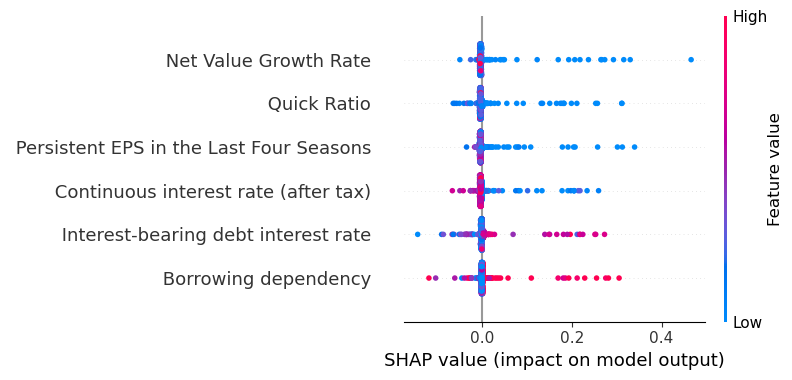

In [173]:
feature_names = X_shap_train.columns
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

In [175]:
#ranking cech - srednia wartosc SHAP
mean_abs = np.abs(shap_values.values).mean(axis=0)
feature_importance = pd.DataFrame({
    'Feature':[f"{i}" for i in (feature_names)], 'Mean SHAP value' : mean_abs})
feature_importance = feature_importance.sort_values('Mean SHAP value', ascending=False)

print(feature_importance)

                                    Feature  Mean SHAP value
3                     Net Value Growth Rate         0.005582
4                               Quick Ratio         0.005210
2   Persistent EPS in the Last Four Seasons         0.004957
0      Continuous interest rate (after tax)         0.004724
1       Interest-bearing debt interest rate         0.003980
5                      Borrowing dependency         0.003230


In [229]:
#Usuwanie kolumny Parch
X_shap_test = X_shap_test.drop(columns=[' Interest-bearing debt interest rate', ' Borrowing dependency'])
X_shap_train = X_shap_train.drop(columns=[' Interest-bearing debt interest rate', ' Borrowing dependency'])
X_train = X_shap_train.values
X_test = X_shap_test.values

In [181]:
#Kolejna predykcja
clf_8 = RandomForestShap(n_trees=20)
clf_8.fit(X_train, y_train)
predictions_8 = clf_8.predict(X_test)

acc =  accuracy(y_test, predictions_8)
print(acc)

0.9648093841642229


In [183]:
# Czas przed usunięciem kolumn
time_before = check_training_time(X_train, y_train)
print(f"Czas trenowania przed: {time_before:.2f} s")

Czas trenowania przed: 40.10 s


In [185]:
# Używamy funkcji predict jako modelu
explainer = shap.Explainer(clf_8.predict, X_train, algorithm="permutation")

# Obliczamy wartości SHAP dla danych testowych
shap_values = explainer(X_test)


PermutationExplainer explainer: 1365it [28:21,  1.25s/it]                          


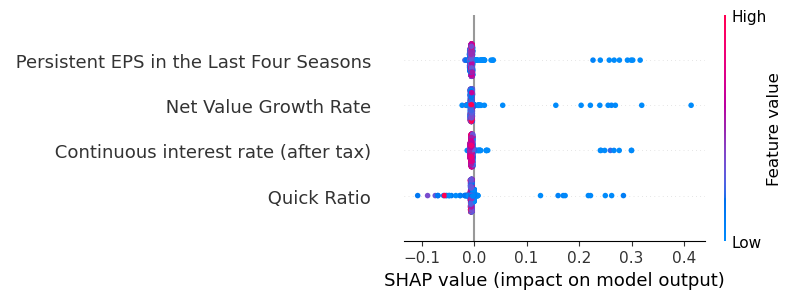

In [187]:
  feature_names = X_shap_train.columns
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

In [189]:
#ranking cech - srednia wartosc SHAP
mean_abs = np.abs(shap_values.values).mean(axis=0)
feature_importance = pd.DataFrame({
    'Feature':[f"{i}" for i in (feature_names)], 'Mean SHAP value' : mean_abs})
feature_importance = feature_importance.sort_values('Mean SHAP value', ascending=False)

print(feature_importance)

                                    Feature  Mean SHAP value
1   Persistent EPS in the Last Four Seasons         0.007335
2                     Net Value Growth Rate         0.007054
0      Continuous interest rate (after tax)         0.006650
3                               Quick Ratio         0.006353


In [231]:
#Usuwanie kolumny Parch
X_shap_test = X_shap_test.drop(columns=[' Continuous interest rate (after tax)', ' Quick Ratio'])
X_shap_train = X_shap_train.drop(columns=[' Continuous interest rate (after tax)', ' Quick Ratio'])
X_train = X_shap_train.values
X_test = X_shap_test.values

In [197]:
# Czas przed usunięciem kolumn
time_before = check_training_time(X_train, y_train)
print(f"Czas trenowania przed: {time_before:.2f} s")

Czas trenowania przed: 17.03 s


In [233]:
#Kolejna predykcja
clf_9 = RandomForestShap(n_trees=20)
clf_9.fit(X_train, y_train)
predictions_9 = clf_9.predict(X_test)

acc =  accuracy(y_test, predictions_9)
print(acc)

0.9633431085043989


In [235]:
# Używamy funkcji predict jako modelu
explainer = shap.Explainer(clf_9.predict, X_train, algorithm="permutation")

# Obliczamy wartości SHAP dla danych testowych
shap_values = explainer(X_test)


DimensionError: The passed data does not match the background shape expected by the masker! The data of shape (3,) was passed while the masker expected data of shape (2,).

In [201]:
#Usuwanie kolumny Parch
X_shap_test = X_shap_test.drop(columns=[' Net Value Growth Rate'])
X_shap_train = X_shap_train.drop(columns=[' Net Value Growth Rate'])
X_train = X_shap_train.values
X_test = X_shap_test.values

In [203]:
#Kolejna predykcja
clf_9 = RandomForestShap(n_trees=20)
clf_9.fit(X_train, y_train)
predictions_9 = clf_9.predict(X_test)

acc =  accuracy(y_test, predictions_9)
print(acc)

0.9648093841642229
